<a href="https://colab.research.google.com/github/PratyushJha254/BTP/blob/main/Model_interpretations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import pickle
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
from keras.utils import to_categorical
import keras.layers as layers
from keras import Sequential
from numba import jit

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import sys
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import seaborn as sns


In [2]:
nu_G = 10
Ny = 64
Nx = 64
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 50
lr = 0.001
beta1 = 0.5
ngpu = 1
N = Ny * Nx
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

### Model

#### Accuracy, train and test functions

In [35]:
def calculate_accuracy(outputs, labels):
    # Threshold the outputs at 0.5 to get binary predictions: below 0.5 becomes 0, above becomes 1
    predicted = (outputs > 0.5).float()

    # The labels need to have the same dimensions as the predictions for comparison
    # Assuming labels are already in the correct shape (batch_size, 1) or (batch_size,)
    # If not, you might need to adjust labels' shape, e.g., labels = labels.view(-1, 1)

    # Calculate the number of correct predictions
    correct = (predicted == labels).float().sum().item()/2

    # Calculate the total number of labels (which is also the batch size)
    total = labels.size(0)

    # Calculate accuracy as the percentage of correct predictions
    accuracy = correct / total
    return accuracy


In [36]:
def train(model, num_epochs, criterion, optimizer, train_dataloader):
  for epoch in range(num_epochs):
    for i, (x, label) in enumerate(train_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      b_size = x.size(0)
      model.zero_grad()
      output = model(x)
      # if(epoch==0 and i==0):
      #   print(output)
      error = criterion(output, label)
      error.backward()
      optimizer.step()
      acc_train = calculate_accuracy(output, label)
      if i % 20 == 0:
        print('Loss:', error.item(),',Train accuracy:', acc_train)

In [54]:
def test(model, criterion, test_dataloader):
    for i, (x, label) in enumerate(test_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      output = model(x)
      error = criterion(output, label)
      acc_train = calculate_accuracy(output, label)
      # if i % 20 == 0:
      print(i,':: Loss:', error.item(),',Test accuracy:', acc_train)

In [38]:
def get_predictions(test_loader, model):
    # Assuming `test_loader` is your DataLoader for the test dataset
    # Initialize lists to store predictions for each class
    predictions_class_1 = []
    predictions_class_2 = []

    with torch.no_grad():  # Disable gradient tracking during inference
        for inputs, _ in test_loader:
            inputs = inputs.to(device).float()  # Move inputs to the device (e.g., GPU)
            outputs = model(inputs)  # Forward pass to get predictions

            # Assuming the output is softmax probabilities
            # Separate the probabilities for class-1 and class-2
            class_1_probs = outputs[:, 0].cpu().numpy()  # Probabilities for class-1
            class_2_probs = outputs[:, 1].cpu().numpy()  # Probabilities for class-2

            predictions_class_1.extend(class_1_probs)
            predictions_class_2.extend(class_2_probs)

    # `predictions_class_1` contains the probabilities for class-1 for all test samples
    # `predictions_class_2` contains the probabilities for class-2 for all test samples
    # You can further process or save these predictions as needed
    return predictions_class_1, predictions_class_2


In [81]:
def get_predictions_np(input_matrix, model, device):
    # Convert numpy matrix to PyTorch tensor
    inputs = torch.tensor(input_matrix).to(device).float()

    # Forward pass to get predictions
    with torch.no_grad():  # Disable gradient tracking during inference
        outputs = model(inputs)  # Forward pass to get predictions

        # Assuming the output is softmax probabilities
        # Separate the probabilities for class-1 and class-2
        class_1_probs = outputs[:, 0].cpu().numpy()  # Probabilities for class-1
        class_2_probs = outputs[:, 1].cpu().numpy()  # Probabilities for class-2

    # `class_1_probs` contains the probabilities for class-1 for all samples
    # `class_2_probs` contains the probabilities for class-2 for all samples
    # You can further process or save these predictions as needed
    return class_1_probs, class_2_probs


#### File loaders

In [42]:
def file_loader(file_name):
    data = np.load(file_name)
    X = data['X']
    y = data['y']
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15)
    Tc = 2.27 # For a square lattice following Ising Model
    y_train = Y_train > Tc
    y_test = Y_test > Tc
    y_train = to_categorical(y_train.astype(int))
    y_test = to_categorical(y_test.astype(int))
    return X_train, X_test, y_train, y_test, Y_train, Y_test

In [43]:
def full_file_loader(file_name):
    data = np.load(file_name)
    X = data['X']
    Y = data['y']
    Tc = 2.27 # For a square lattice following Ising Model
    y = Y > Tc
    y = to_categorical(y.astype(int))
    return X, y, Y

#### Dataset and DataLoader

In [39]:
class IsingDataset(Dataset):
    def __init__(self, x, y, anti_ferro=False):
        self.n_samples = x.shape[0]
        self.x = torch.tensor(torch.from_numpy(x))
        self.y = torch.tensor(torch.from_numpy(y))
        self.anti_ferro = anti_ferro

    def __getitem__(self, index):
        if self.anti_ferro:
            x_transformed = self._apply_anti_ferro(self.x[index])
            return x_transformed, self.y[index]
        else:
            return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

    def _apply_anti_ferro(self, x):
        # Apply anti-ferromagnetic transformation
        return (-1) ** torch.arange(x.size(0)).unsqueeze(1) + (-1) ** torch.arange(x.size(1))

# # Example usage
# x = ...  # Your input data
# y = ...  # Your target labels
# anti_ferro = True  # Set to True to apply the anti-ferromagnetic transformation
# dataset = IsingDataset(x, y, anti_ferro=anti_ferro)


#### Fully Connected Neural Network

In [40]:
class neural_network(nn.Module):
  def __init__(self):
    super(neural_network, self).__init__()
    self.main = nn.Sequential(
        nn.Flatten(start_dim=1,end_dim=-1),
        nn.Linear(Nx*Ny, 100),
        nn.Sigmoid(),
        nn.Linear(100, 2),
        nn.Sigmoid()
    )
  def forward(self, input):
      return self.main(input)

In [41]:
FCNN = neural_network().to(device)
criterion_FCNN = nn.BCELoss()
optimizer_FCNN = optim.Adam(FCNN.parameters(), lr=lr, betas=(0.9, 0.999))

In [94]:
# Dataset 1, NN -> antiFe, NNN -> Fe
X_anti, y_anti, Y_anti = full_file_loader('data_anti.npz')
dataset_anti = IsingDataset(X_anti, y_anti)
batch_size = 128
dataloader_anti = DataLoader(dataset = dataset_anti, batch_size = batch_size, shuffle = False)

<ipython-input-39-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-39-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [95]:
test(FCNN, criterion_FCNN, dataloader_anti)

0 :: Loss: 0.09835169464349747 ,Test accuracy: 0.9921875
1 :: Loss: 0.11220943182706833 ,Test accuracy: 0.96875
2 :: Loss: 0.09511858969926834 ,Test accuracy: 0.96875
3 :: Loss: 0.042947374284267426 ,Test accuracy: 1.0
4 :: Loss: 0.08519921451807022 ,Test accuracy: 0.9609375
5 :: Loss: 0.1172829195857048 ,Test accuracy: 0.97265625
6 :: Loss: 0.07050792872905731 ,Test accuracy: 0.9765625
7 :: Loss: 0.04197850450873375 ,Test accuracy: 1.0
8 :: Loss: 0.05625773221254349 ,Test accuracy: 0.984375
9 :: Loss: 0.03768795728683472 ,Test accuracy: 1.0
10 :: Loss: 0.04276963695883751 ,Test accuracy: 1.0
11 :: Loss: 0.0874142125248909 ,Test accuracy: 0.9765625
12 :: Loss: 0.04084184393286705 ,Test accuracy: 1.0
13 :: Loss: 0.11214948445558548 ,Test accuracy: 0.984375
14 :: Loss: 0.057352110743522644 ,Test accuracy: 0.984375
15 :: Loss: 0.0634307712316513 ,Test accuracy: 0.9921875
16 :: Loss: 0.07046818733215332 ,Test accuracy: 0.984375
17 :: Loss: 0.08774729818105698 ,Test accuracy: 0.96875
18 :: 

### Testing on NNN data

#### Loading the datasets and the trained model

In [5]:
# Dataset 1, NN -> antiFe, NNN -> Fe
X1, y1, Y1 = full_file_loader('data_64NNN_antiferroNN_ferroNNN_R2.npz')

In [6]:
# Dataset 2, NN -> antiFe
X2, y2, Y2 = full_file_loader('data_anti.npz')

In [32]:
# Dataset 3, NN -> antiFe, NNN -> Fe, reduced
X3, y3, Y3 = full_file_loader('data_64NNN_anti_noshuffle.npz')

In [44]:
dataset1 = IsingDataset(X1, y1)
dataset2 = IsingDataset(X2, y2)
dataset3 = IsingDataset(X3, y3)
batch_size = 128
dataloader1 = DataLoader(dataset = dataset1, batch_size = batch_size, shuffle = False)
dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)
dataloader3 = DataLoader(dataset = dataset3, batch_size = batch_size, shuffle = False)

<ipython-input-39-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-39-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [48]:
FCNN.load_state_dict(torch.load('NeuralNetwork_weights_anti64.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

FCNN

In [53]:
dataset3.__len__()

2200

In [55]:
test(FCNN, criterion_FCNN, dataloader3)

0 :: Loss: 0.9899082779884338 ,Test accuracy: 0.5546875
1 :: Loss: 0.8000156879425049 ,Test accuracy: 0.640625
2 :: Loss: 1.0199850797653198 ,Test accuracy: 0.4609375
3 :: Loss: 0.8156412243843079 ,Test accuracy: 0.56640625
4 :: Loss: 0.8659534454345703 ,Test accuracy: 0.57421875
5 :: Loss: 0.6298913955688477 ,Test accuracy: 0.703125
6 :: Loss: 0.476893812417984 ,Test accuracy: 0.73046875
7 :: Loss: 0.410022497177124 ,Test accuracy: 0.84375
8 :: Loss: 0.4263375401496887 ,Test accuracy: 0.81640625
9 :: Loss: 0.5571684837341309 ,Test accuracy: 0.78125
10 :: Loss: 0.45419707894325256 ,Test accuracy: 0.78515625
11 :: Loss: 0.6223741769790649 ,Test accuracy: 0.8046875
12 :: Loss: 0.4041638970375061 ,Test accuracy: 0.83203125
13 :: Loss: 0.5794614553451538 ,Test accuracy: 0.7890625
14 :: Loss: 0.6049662828445435 ,Test accuracy: 0.7734375
15 :: Loss: 0.7353665232658386 ,Test accuracy: 0.7265625
16 :: Loss: 0.6186746954917908 ,Test accuracy: 0.7734375
17 :: Loss: 0.693280041217804 ,Test accura

In [56]:
pred_class1, pred_class2 = get_predictions(dataloader3, FCNN)

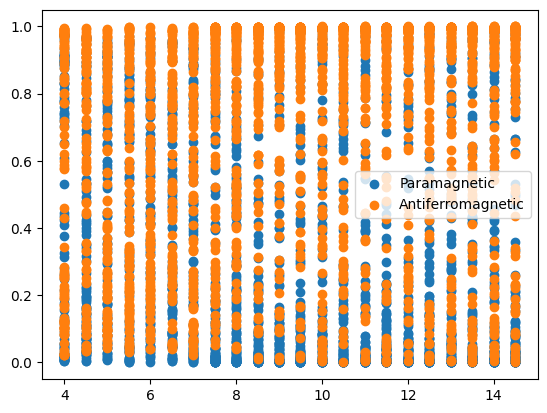

In [65]:
plt.scatter(Y3, pred_class1, label='Paramagnetic')
plt.scatter(Y3, pred_class2, label='Antiferromagnetic')
plt.legend()

In [ ]:
test()

#### Data Visualization

In [25]:
for idx, i in enumerate(Y2):
  if i>3:
    print(idx)
    print(i)
    break

3
3.1


Text(0.5, 1.0, 'Temperature = 3.1')

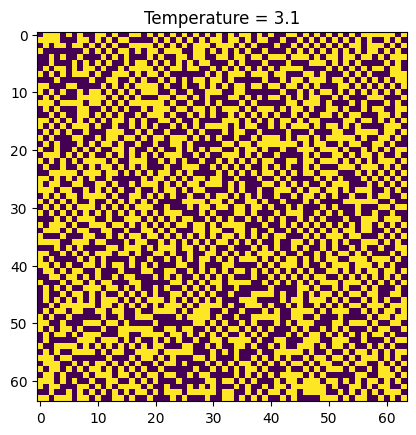

In [28]:
plt.imshow(X2[3])
plt.title(f"Temperature = {Y2[3]}")

Text(0.5, 1.0, 'Temperature = 1.4')

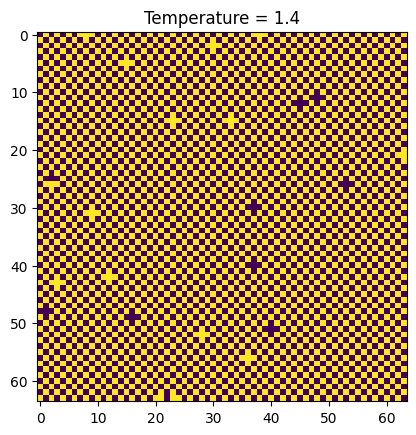

In [20]:
plt.imshow(X2[0])
plt.title(f"Temperature = {Y2[0]}")

In [74]:
# Class 1 -> Paramagnetic, Class 2 -> Antiferromagnetic ([0. 1.] -> AFM)
## Samples getting predicted incorrectly:
for index in range(dataset3.__len__()):
    if(np.round(pred_class1[index]) != y3[index][0]):
        print(f"\033[1mIndex: {index}\033[0m")
        print(f"PREDICTED: {pred_class1[index]}, {pred_class2[index]}")
        print(f"EXPECTED: {y3[index]}")

Index: 1
PREDICTED: 0.5311572551727295, 0.4595322012901306
EXPECTED: [0. 1.]
Index: 12
PREDICTED: 0.723466694355011, 0.26100102066993713
EXPECTED: [0. 1.]
Index: 13
PREDICTED: 0.8141891360282898, 0.19164887070655823
EXPECTED: [0. 1.]
Index: 14
PREDICTED: 0.8285818099975586, 0.17124028503894806
EXPECTED: [0. 1.]
Index: 15
PREDICTED: 0.8844856023788452, 0.12055635452270508
EXPECTED: [0. 1.]
Index: 16
PREDICTED: 0.9021286368370056, 0.10343020409345627
EXPECTED: [0. 1.]
Index: 17
PREDICTED: 0.8885172009468079, 0.11898777633905411
EXPECTED: [0. 1.]
Index: 18
PREDICTED: 0.914458155632019, 0.09235038608312607
EXPECTED: [0. 1.]
Index: 19
PREDICTED: 0.9227880835533142, 0.08514466881752014
EXPECTED: [0. 1.]
Index: 21
PREDICTED: 0.7399397492408752, 0.2559666037559509
EXPECTED: [0. 1.]
Index: 22
PREDICTED: 0.8775912523269653, 0.1254274547100067
EXPECTED: [0. 1.]
Index: 23
PREDICTED: 0.9184772372245789, 0.08476530760526657
EXPECTED: [0. 1.]
Index: 24
PREDICTED: 0.8993380665779114, 0.105645462870597

---
A few datapoints from the above printed data: <br>
<small><b>Index: 1</b> <br>
PREDICTED: 0.5311572551727295, 0.4595322012901306 <br>
EXPECTED: [0. 1.]<br>
<b>Index: 12</b><br>
PREDICTED: 0.723466694355011, 0.26100102066993713<br>
EXPECTED: [0. 1.]<br>
<b>Index: 13 </b><br>
PREDICTED: 0.8141891360282898, 0.19164887070655823<br>
EXPECTED: [0. 1.]<br></small>

PREDICTED: 0.02166641131043434, 0.971859335899353
EXPECTED: [0. 1.]


Text(0.5, 1.0, 'Temperature = 4.0')

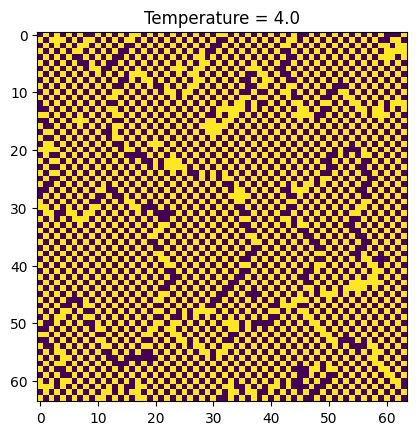

In [78]:
index = 0
print(f"PREDICTED: {pred_class1[index]}, {pred_class2[index]}")
print(f"EXPECTED: {y3[index]}")
plt.imshow(X3[index])
plt.title(f"Temperature = {Y3[index]}")

PREDICTED: 0.8141891360282898, 0.19164887070655823
EXPECTED: [0. 1.]


Text(0.5, 1.0, 'Temperature = 4.0')

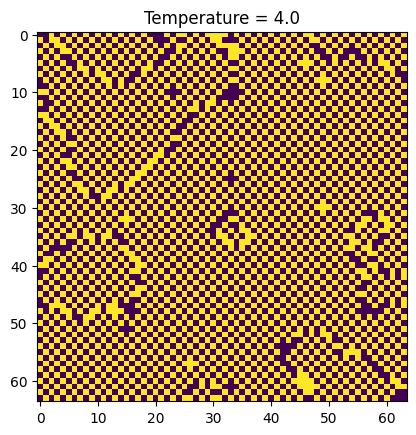

In [77]:
index = 13
print(f"PREDICTED: {pred_class1[index]}, {pred_class2[index]}")
print(f"EXPECTED: {y3[index]}")
plt.imshow(X3[index])
plt.title(f"Temperature = {Y3[index]}")

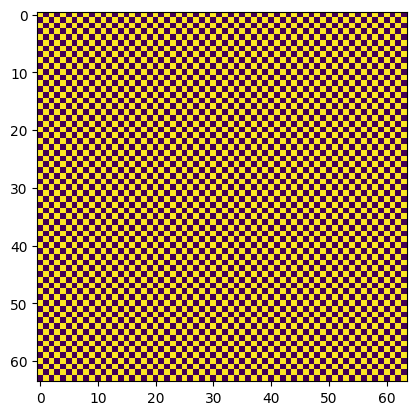

In [90]:
test_input1 = np.ones((1, 64, 64))  # Add an additional dimension for batch size of 1
test_input1[:, 1::2, ::2] = -1
test_input1[:, ::2, 1::2] = -1

plt.imshow(test_input1.squeeze())  # Squeeze the batch dimension for visualization
plt.show()

In [96]:
# Resolve the error
pred_c1, pred_c2 = get_predictions_np(test_input1*(-1), FCNN, device)

In [97]:
print(f"{pred_c1}, {pred_c2}")

[0.96203], [0.04136122]


TO-DO List:
1. Print class attribution maps
2. Transfer learning in FCNN
3. Check for CNN